- **Librerías**

In [1]:
import cdsapi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from netCDF4 import Dataset
from netCDF4 import Dataset, num2date
from datetime import datetime, timedelta
from matplotlib import cm
import pytz
from pytz import timezone
from matplotlib import font_manager as fm
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pylab as pl


import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')

In [2]:
path_font=r"G:\My drive\TESIS_MAESTRIA_PAULAE\Fonts\Quicksand"

prop1 = fm.FontProperties(fname=path_font+'\Quicksand-Medium.ttf')
prop2 = fm.FontProperties(fname=path_font+'\Quicksand-SemiBold.ttf')
prop1.set_size(12)

# Descargar los datos de ERA5

Please note that the ERA5 native grid of online CDS is 0.25°x0.25° (atmosphere), 0.5°x0.5° (ocean waves), mean, spread and members: 0.5°x0.5° (atmosphere), 1°x1° (ocean waves). ERA5-Land: 0.1°x0.1°. So this will be returned by default.

https://confluence.ecmwf.int/display/CKB/How+to+download+ERA5#HowtodownloadERA5-4-DownloadERA5familydatathroughtheCDSAPI

Se descargan los datos de la base de datos ERA 5

Descargar Api: https://cds.climate.copernicus.eu/api-how-to

In [3]:
# c = cdsapi.Client()

# c.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'format': 'netcdf',
#         'variable': [
#             'mean_wave_direction', 'peak_wave_period', 'significant_height_of_combined_wind_waves_and_swell',
#         ],
#         'year': [ '2021',
#         ],
#         'month': [
#         '10', '11',
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': 
#             '00:00/ 01:00/ 02:00/03:00/ 04:00/ 05:00/06:00/ 07:00/ 08:00/ 09:00/ 10:00/ 11:00/12:00/ 13:00/ 14:00/15:00/ 16:00/ 17:00/18:00/ 19:00/ 20:00/21:00/ 22:00/23:00'
#         ,
#         'area':[
#             '12.875','278','12.25','278.625',
#         ],
#         'grid':[
#             '0.125','0.125',
#         ],
#         'step' :"0"
#     },
#     'data_wave_MG.nc')

In [3]:
data = Dataset('data_wave_MG.nc','r')
data.variables

{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
     long_name: longitude
 unlimited dimensions: 
 current shape = (6,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
     long_name: latitude
 unlimited dimensions: 
 current shape = (6,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:00.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: 
 current shape = (1464,)
 filling on, default _FillValue of -2147483647 used,
 'mwd': <class 'netCDF4._netCDF4.Variable'>
 int16 mwd(time, latitude, longitude)
     scale_factor: 0.001146957496767753
     add_offset: 46.49030605692666
     _FillValue: -32767
     missing_value: -32767
     units: Degree true
     long_name: Mean wave directio

In [4]:
%%time
lat_wave = np.array(data.variables['latitude'][:])
lon_wave = np.array(data.variables['longitude'][:])
nctime_wave = np.array(data.variables['time'][:])
t_unit_wave = data.variables['time'].units
t_cal_wave = data.variables['time'].calendar
time_wave = num2date(nctime_wave,units=t_unit_wave,calendar=t_cal_wave)#Date time
hs = np.array(data.variables['swh'][:])
tp = np.array(data.variables['pp1d'][:])
direc = np.array(data.variables['mwd'][:])

CPU times: total: 0 ns
Wall time: 28.4 ms


In [5]:
# Cambiar la zona horaria utc 0 a utc -5
utc = pytz.utc
col_zone = timezone('America/Bogota')
time2=np.array([datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time_wave])
loc_co =np.array([i.astimezone(col_zone) for i in time2])
time_wave = np.array([datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])
time_wave

array([datetime.datetime(2021, 9, 30, 19, 0),
       datetime.datetime(2021, 9, 30, 20, 0),
       datetime.datetime(2021, 9, 30, 21, 0), ...,
       datetime.datetime(2021, 11, 30, 16, 0),
       datetime.datetime(2021, 11, 30, 17, 0),
       datetime.datetime(2021, 11, 30, 18, 0)], dtype=object)

In [6]:
date_ini = datetime(2021,11,2,1) # Parámetro a variar
date_fin = datetime(2021,11,14,16) # Parámetro a variar
ind_ini_fin = np.where((time_wave==date_ini)|(time_wave==date_fin))[0]
time_d3d_wave = time_wave[ind_ini_fin[0]:ind_ini_fin[1]]
print(ind_ini_fin)
print(time_d3d_wave.shape)

[ 774 1077]
(303,)


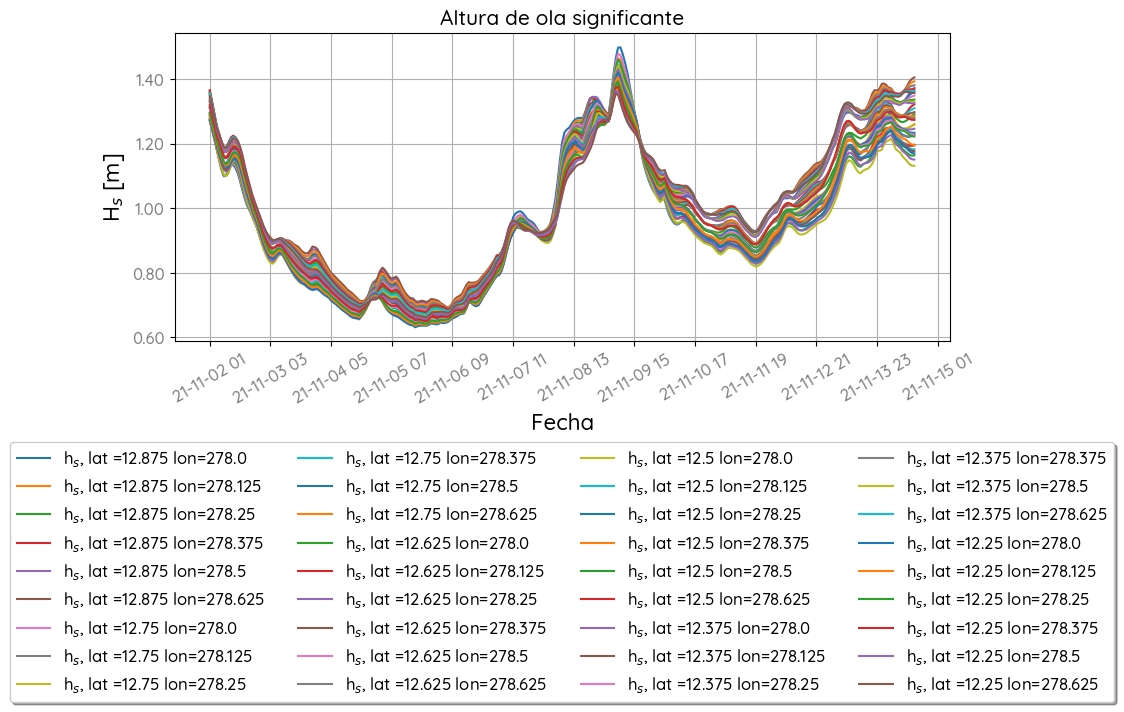

In [10]:
hourticks = ((time_d3d_wave[-1]-time_d3d_wave[0]).days*24 +(time_d3d_wave[-1]-time_d3d_wave[0]).seconds/3600+12) # Mover parámetro 12
xticks_time = np.array([time_d3d_wave[0] + timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12

fig, ax = plt.subplots(figsize=(10,4))
for i in range(len(lat_wave)):
    for j in range(len(lon_wave)):
        ax.plot(time_d3d_wave, hs[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'h$_s$, lat ='+str(lat_wave[i])+ ' lon='+str(lon_wave[j]))
#         ax.plot(time_d3d_wave, v10_wave[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'v$_{10}$, lat ='+str(lat_wave[i])+ ' lon='+str(lon_wave[j]))
ax.set_xticks(xticks_time)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel ('Fecha',size=16,fontproperties=prop1)
ax.set_ylabel ('H$_{s}$ [m]',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
for label in ax.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title('Altura de ola significante',size = 15,fontproperties=prop1)   # Subtítulo de la figura
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation=30)
ax.grid(True)

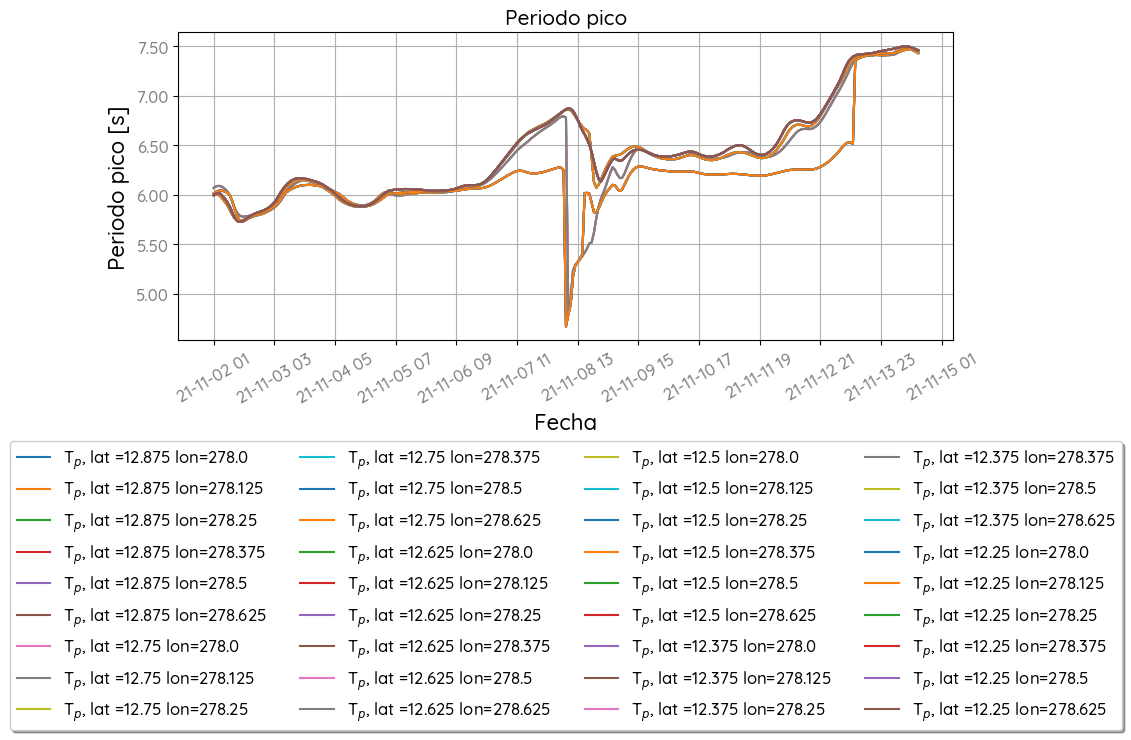

In [11]:
hourticks = ((time_d3d_wave[-1]-time_d3d_wave[0]).days*24 +(time_d3d_wave[-1]-time_d3d_wave[0]).seconds/3600+12) # Mover parámetro 12
xticks_time = np.array([time_d3d_wave[0] + timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12

fig, ax = plt.subplots(figsize=(10,4))
for i in range(len(lat_wave)):
    for j in range(len(lon_wave)):
        ax.plot(time_d3d_wave, tp[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'T$_p$, lat ='+str(lat_wave[i])+ ' lon='+str(lon_wave[j]))
#         ax.plot(time_d3d_wave, v10_wave[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'v$_{10}$, lat ='+str(lat_wave[i])+ ' lon='+str(lon_wave[j]))
ax.set_xticks(xticks_time)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel ('Fecha',size=16,fontproperties=prop1)
ax.set_ylabel ('Periodo pico [s]',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
for label in ax.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title('Periodo pico',size = 15,fontproperties=prop1)   # Subtítulo de la figura
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation=30)
ax.grid(True)

In [12]:
lat_wave

array([12.875, 12.75 , 12.625, 12.5  , 12.375, 12.25 ], dtype=float32)

In [19]:
def TEPAR_files_swan(filename,lon, lat, Latitud, Longitud, time_wave, hs, tp, direc , date_ini = datetime(2021,11,2,1), date_fin = datetime(2021,11,14,16)):
    """
    filename: Nombre del archivo
    Lon: Coordenada longitudinal del punto de interés
    Lat: Coordenada latitudinal del punto de interés
    Latitud: Serie de coordenadas latitudinales
    Longitud: Serie de coordenadas longitudinales
    date_ini: fecha inicial de la serie de datos
    date_fin: Fecha final de la serie de datos
    """
    in_lat = np.where((Latitud == lat))[0]
    in_lon = np.where((Longitud == lon))[0]
    ind_ini_fin = np.where((time_wave==date_ini)|(time_wave==date_fin))[0]
    
    time_d3d_wave = time_wave[ind_ini_fin[0]:ind_ini_fin[1]]
    str_time_wave =[time_d3d_wave[i].strftime("%Y%m%d.%H%M") for i in range( len(time_d3d_wave))]
    Hs = hs[ind_ini_fin[0]:ind_ini_fin[1], in_lat, in_lon]
    Hs = [Hs[i][0] for i in range(len(Hs))]
    Tp = tp[ind_ini_fin[0]:ind_ini_fin[1], in_lat, in_lon]
    Tp = [Tp[i][0] for i in range(len(Tp))]
    Direc = direc[ind_ini_fin[0]:ind_ini_fin[1], in_lat, in_lon]
    Direc = [Direc[i][0] for i in range(len(Direc))]
    Des_direc = list(np.ones(shape=len(Direc))*40)
    Dir_Param = {'Time':str_time_wave, 'Hs': Hs, 'Tp': Tp, 'Direc': Direc, 'Des_Dirc': Des_direc}
    df_data = pd.DataFrame(data = Dir_Param)
    with open (filename+'.bnd', "w") as f:
        f.write("TPAR \n")
        np.savetxt(f,df_data,fmt =('%s  %7.9f  %8.9f  %9.9f  %5.1f'))
    return df_data

In [29]:
# Note:
Boundary = 'Norte'
longitudes = [278.125,278.250, 278.375, 278.5]
lat = 12.750
for i in range (len(longitudes)):
    df_data = TEPAR_files_swan(Boundary + str(i+1),longitudes[i], lat, lat_wave, lon_wave, time_wave, hs, tp, direc , date_ini = datetime(2021,11,2,0), date_fin = datetime(2021,11,14,22))

In [30]:
# Sur:
Boundary = 'Sur'
longitudes = [278.125,278.250, 278.375, 278.5]
lat = 12.375
for i in range (len(longitudes)):
    df_data = TEPAR_files_swan(Boundary + str(i+1),longitudes[i], lat, lat_wave, lon_wave, time_wave, hs, tp, direc , date_ini = datetime(2021,11,2,0), date_fin = datetime(2021,11,14,22))

In [31]:
# Sur:
Boundary = 'Oeste'
latitudes = [12.375, 12.5, 12.625, 12.750]
lon = 278.125
for i in range (len(latitudes)):
    df_data = TEPAR_files_swan(Boundary + str(i+1),lon, latitudes[i], lat_wave, lon_wave, time_wave, hs, tp, direc , date_ini = datetime(2021,11,2,0), date_fin = datetime(2021,11,14,22))

In [32]:
# Sur:
Boundary = 'Este'
latitudes = [12.375, 12.5, 12.625, 12.750]
lon = 278.125
for i in range (len(latitudes)):
    df_data = TEPAR_files_swan(Boundary + str(i+1),lon, latitudes[i], lat_wave, lon_wave, time_wave, hs, tp, direc , date_ini = datetime(2021,11,2,0), date_fin = datetime(2021,11,14,22))

In [33]:
df_data

,Time,Hs,Tp,Direc,Des_Dirc
0,20211102.0000,1.319898,6.040853,71.352904,40.0
1,20211102.0100,1.292276,6.070134,71.390753,40.0
2,20211102.0200,1.260714,6.085817,71.436632,40.0
3,20211102.0300,1.227264,6.091191,71.471040,40.0
4,20211102.0400,1.194531,6.087791,71.492833,40.0
...,...,...,...,...,...
305,20211114.1700,1.242512,7.447591,73.596353,40.0
306,20211114.1800,1.261326,7.442766,73.066458,40.0
307,20211114.1900,1.278411,7.440024,72.590471,40.0
308,20211114.2000,1.291610,7.438050,72.138570,40.0


# Archivo de vientos 

Descarga de datos

In [16]:
# %%time
# c = cdsapi.Client()

# c.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'format': 'netcdf',
#         'variable': [
#             '10m_u_component_of_wind', '10m_v_component_of_wind',
#         ],
#         'year': [
#              '2021',
#         ],
#         'month': [
            
#             '10', '11', 
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': [
#             '00:00', '01:00', '02:00',
#             '03:00', '04:00', '05:00',
#             '06:00', '07:00', '08:00',
#             '09:00', '10:00', '11:00',
#             '12:00', '13:00', '14:00',
#             '15:00', '16:00', '17:00',
#             '18:00', '19:00', '20:00',
#             '21:00', '22:00', '23:00',
#         ],
#         'area':[
#             '12.875','278','12.25','278.625',
#         ],
#         'grid':[
#             '0.125','0.125',
#         ],
#     },
#     'data_wind_10_11_125.nc')

In [34]:
data = Dataset('data_wind_10_11_125.nc','r')
data.variables

{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
     long_name: longitude
 unlimited dimensions: 
 current shape = (6,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
     long_name: latitude
 unlimited dimensions: 
 current shape = (6,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:00.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: 
 current shape = (1464,)
 filling on, default _FillValue of -2147483647 used,
 'u10': <class 'netCDF4._netCDF4.Variable'>
 int16 u10(time, latitude, longitude)
     scale_factor: 0.00018869329346164382
     add_offset: -4.233119510058825
     _FillValue: -32767
     missing_value: -32767
     units: m s**-1
     long_name: 10 metre U wind com

In [35]:
%%time
lat = np.array(data.variables['latitude'][:])
lon = np.array(data.variables['longitude'][:])
nctime = np.array(data.variables['time'][:])
t_unit = data.variables['time'].units
t_cal = data.variables['time'].calendar
time = num2date(nctime,units=t_unit,calendar=t_cal)#Date time
u10 = np.array(data.variables['u10'][:])
v10 = np.array(data.variables['v10'][:])

CPU times: total: 15.6 ms
Wall time: 16.5 ms


In [36]:
utc = pytz.utc
col_zone = timezone('America/Bogota')
time2=np.array([datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time])
loc_co =np.array([i.astimezone(col_zone) for i in time2])
time = np.array([datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])
time

array([datetime.datetime(2021, 9, 30, 19, 0),
       datetime.datetime(2021, 9, 30, 20, 0),
       datetime.datetime(2021, 9, 30, 21, 0), ...,
       datetime.datetime(2021, 11, 30, 16, 0),
       datetime.datetime(2021, 11, 30, 17, 0),
       datetime.datetime(2021, 11, 30, 18, 0)], dtype=object)

In [37]:
date_ini = datetime(2021,11,2,0) # Parámetro a variar
date_fin = datetime(2021,11,14,17) # Parámetro a variar
ind_ini_fin = np.where((time==date_ini)|(time==date_fin))[0]
time_d3d_wind = time[ind_ini_fin[0]:ind_ini_fin[1]]
hours = np.array([((time_d3d_wind[i] - time_d3d_wind[0]).days*24)+((time_d3d_wind[i] - time_d3d_wind[0]).seconds/3600) for i in range (0,len(time_d3d_wind))])
minutes = np.array([((time_d3d_wind[i] - time_d3d_wind[0]).days*1440)+((time_d3d_wind[i] - time_d3d_wind[0]).seconds/60) for i in range (0,len(time_d3d_wind))])
data_u10 = u10[ind_ini_fin[0]:ind_ini_fin[1],:,:]
data_v10 = v10[ind_ini_fin[0]:ind_ini_fin[1],:,:]

In [39]:
#Se hace el recorte del vector
q1=np.where(np.asarray(time_d3d_wind[:])==time_d3d_wind[0])[0]
q2=np.where(np.asarray(time_d3d_wind[:])==time_d3d_wind[-1])[0]
# with open ("wind_octubre_noviembre_2022.wnd",'w') as f:# Aquí se crea el archivo.txt
#     for i in range(q1[0],q2[0]):
#         f.write("%s\n" % time_d3d_wind[i].strftime("%Y%m%d %H%M%S"))
#         np.savetxt(f,data_u10[i,:,:])#,fmt='%10.4f')
#         np.savetxt(f,data_v10[i,:,:])#,fmt='%10.4f')

In [40]:
with open ("xy_wind.wnd",'w') as f:# Aquí se crea el archivo.txt
    for i in range(q1[0],q2[0]):
        f.write("Time = %5.1f" % minutes[i] + " minutes since " + "%s" % time_d3d_wind[i].strftime("%Y-%m-%d %H:%M:%S") + " +00:00 \n")
        np.savetxt(f,data_u10[i,:,:])#,fmt='%10.4f')
        np.savetxt(f,data_v10[i,:,:])#,fmt='%10.4f')

In [86]:
with open ("y_wind.wnd",'w') as f:# Aquí se crea el archivo.txt
    for i in range(q1[0],q2[0]):
        f.write("Time = %5.1f" % hours[i] + " minutes since " + "%s" % time_d3d_wind[i].strftime("%Y-%m-%d %H:%M:%S") + " +00:00 \n")
#         np.savetxt(f,data_u10[i,:,:])#,fmt='%10.4f')
        np.savetxt(f,data_v10[i,:,:])#,fmt='%10.4f')

In [80]:
0.125*111300

13912.5

# HEAT FLUX 

In [15]:
%%time
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            'total_cloud_cover', '2m_dewpoint_temperature','2m_temperature', 'mean_surface_downward_short_wave_radiation_flux',
        ],
        'year': [
             '2021',
        ],
        'month': [
            
            '10', '11', 
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area':[
            '12.875','278','12.25','278.625',
        ],
        'grid':[
            '0.125','0.125',
        ],
    },
    'data_heat_flux_ocean_10_11_125.nc')

2022-12-30 15:19:41,891 INFO Welcome to the CDS
2022-12-30 15:19:41,891 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2022-12-30 15:19:42,335 INFO Request is queued
2022-12-30 15:19:43,566 INFO Request is running
2022-12-30 15:24:04,076 INFO Request is completed
2022-12-30 15:24:04,076 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data5/adaptor.mars.internal-1672431778.1971633-17996-16-4b7b84a1-46cb-4527-b8af-ea98d0d6a663.nc to data_heat_flux_ocean_10_11_125.nc (419.4K)
2022-12-30 15:24:07,062 INFO Download rate 140.5K/s


CPU times: total: 172 ms
Wall time: 4min 26s


Result(content_length=429424,content_type=application/x-netcdf,location=https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data5/adaptor.mars.internal-1672431778.1971633-17996-16-4b7b84a1-46cb-4527-b8af-ea98d0d6a663.nc)

In [3]:
data = Dataset('data_heat_flux_ocean_10_11_125.nc','r')
data.variables

{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
     long_name: longitude
 unlimited dimensions: 
 current shape = (6,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
     long_name: latitude
 unlimited dimensions: 
 current shape = (6,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:00.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: 
 current shape = (1464,)
 filling on, default _FillValue of -2147483647 used,
 'tcc': <class 'netCDF4._netCDF4.Variable'>
 int16 tcc(time, latitude, longitude)
     scale_factor: 1.525958854494026e-05
     add_offset: 0.49999567826351254
     _FillValue: -32767
     missing_value: -32767
     units: (0 - 1)
     long_name: Total cloud cover
 

In [4]:
%%time
lat = np.array(data.variables['latitude'][:])
lon = np.array(data.variables['longitude'][:])
nctime = np.array(data.variables['time'][:])
t_unit = data.variables['time'].units
t_cal = data.variables['time'].calendar
time = num2date(nctime,units=t_unit,calendar=t_cal)#Date time
tcc = np.array(data.variables['tcc'][:]) # total cloud cover
d2m = np.array(data.variables['d2m'][:]) # dwepoint temperature
t2m = np.array(data.variables['t2m'][:]) # 2m temperature
ssr = np.array(data.variables['msdrswrf'][:]) # surface solar radiation

CPU times: total: 0 ns
Wall time: 35.1 ms


In [12]:
utc = pytz.utc
# zones = pytz.all_timezones # Vew all timezones
# print(zones)

col_zone = timezone('America/Bogota')
# col_zone = timezone('GMT')

time2=np.array([datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time])
loc_co =np.array([i.astimezone(col_zone) for i in time2])
time = np.array([datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])
time

date_ini = datetime(2021,11,2,0) # Parámetro a variar
date_fin = datetime(2021,11,2,23) # Parámetro a variar
ind_ini_fin = np.where((time==date_ini)|(time==date_fin))[0]
time_d3d_wind = time[ind_ini_fin[0]:ind_ini_fin[1]]
print(ind_ini_fin)
print(time_d3d_wind.shape)

[773 796]
(23,)


In [13]:
time

array([datetime.datetime(2021, 9, 30, 19, 0),
       datetime.datetime(2021, 9, 30, 20, 0),
       datetime.datetime(2021, 9, 30, 21, 0), ...,
       datetime.datetime(2021, 11, 30, 16, 0),
       datetime.datetime(2021, 11, 30, 17, 0),
       datetime.datetime(2021, 11, 30, 18, 0)], dtype=object)

**Plotear las series temporales en todos los pixeles para ver su varianza y elegir un pixel** 

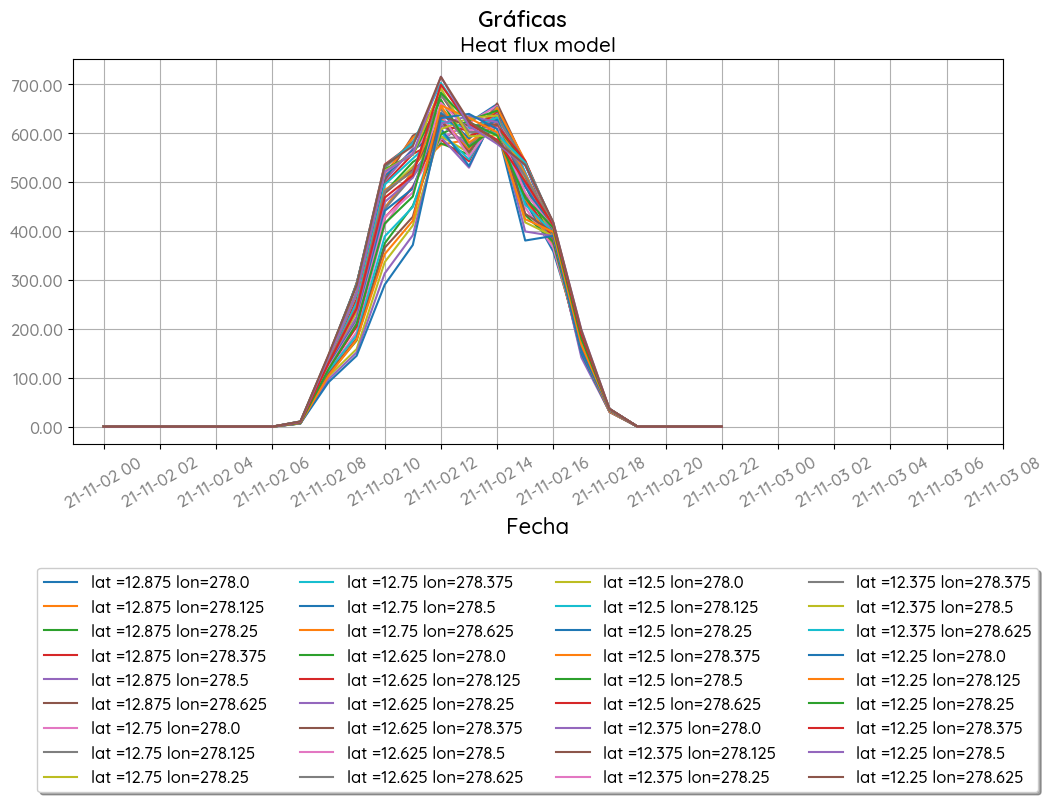

In [14]:
hourticks = ((time_d3d_wind[-1]-time_d3d_wind[0]).days*24 +(time_d3d_wind[-1]-time_d3d_wind[0]).seconds/3600+12) # Mover parámetro 12
xticks_time = np.array([time_d3d_wind[0] + timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12

fig, ax = plt.subplots(figsize=(12,5))
for i in range(len(lat)):
    for j in range(len(lon)):
        # ax.plot(time_d3d_wind, tcc[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'lat ='+str(lat[i])+ ' lon='+str(lon[j]))
        # ax.plot(time_d3d_wind, d2m[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'lat ='+str(lat[i])+ ' lon='+str(lon[j]))
        # ax.plot(time_d3d_wind, t2m[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'lat ='+str(lat[i])+ ' lon='+str(lon[j]))
        ax.plot(time_d3d_wind, ssr[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'lat ='+str(lat[i])+ ' lon='+str(lon[j]))

# ax.plot(time_d3d, ft_west_a, label = 'f$_t$_1', ms=5, color = 'k')
# ax.plot(time_d3d, ft_south_b, label = 'f$_t$_2', ms=5)
# ax.plot(time_d3d, ft_east_b, label = 'f$_t$_3', ms=5, color = 'c')
# ax.plot(time_d3d, ft_north_a, label = 'f$_t$_4', ms=5,color = 'green')
ax.set_xticks(xticks_time)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel ('Fecha',size=16,fontproperties=prop1)
# ax.set_ylabel ('vel$_{wind}$',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
for label in ax.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig.suptitle("Gráficas", size = 16,fontproperties=prop2)     # Titulo de la figura
ax.set_title('Heat flux model',size = 15,fontproperties=prop1)   # Subtítulo de la figura
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation=30)
ax.grid(True)

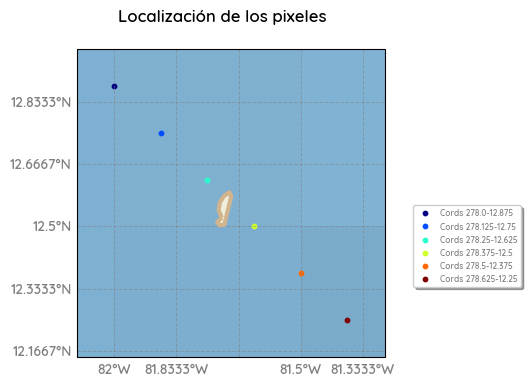

In [14]:
# lon = 360+Cords[:,0]
# lat = Cords[:,1]
fig = plt.figure(figsize = (7,4))
ax1 = fig.add_subplot(projection = ccrs.PlateCarree())
ax1.set_extent([np.min(lon)-0.1,np.max(lon)+0.1, np.min(lat)-0.1, np.max(lat)+0.1])

gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
ax1.stock_img()
ax1.add_feature(cf.LAND, zorder= 10)
ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan', zorder = 11 )
# ax1.add_feature(cf.RIVERS, lw = 2)
ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')


colors_cm = pl.cm.jet(np.linspace(0,1, len(lon)))
i = 0
for loni, lati in zip (lon, lat):
    ax1.scatter(loni, lati, marker = 'o', s = 10, label = 'Cords '+str(loni)+'-'+str(lati), color = colors_cm[i])
    i=i+1
ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')

#------------ Labels de cartopy--------------- 
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}


ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')

prop2.set_size(6)
_= fig.legend(loc='upper center', bbox_to_anchor=(0.85, 0.5),
          fancybox=True, shadow=True, ncol=1, fontsize = 8,prop=prop2, labelcolor = 'gray')
fig.suptitle('Localización de los pixeles',size=12,fontproperties=prop2);
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.25)

In [15]:
df_cords = pd.DataFrame({'Lon':lon, 'Lat':lat})
df_cords

,Lon,Lat
0,278.000,12.875
1,278.125,12.750
2,278.250,12.625
3,278.375,12.500
4,278.500,12.375
5,278.625,12.250


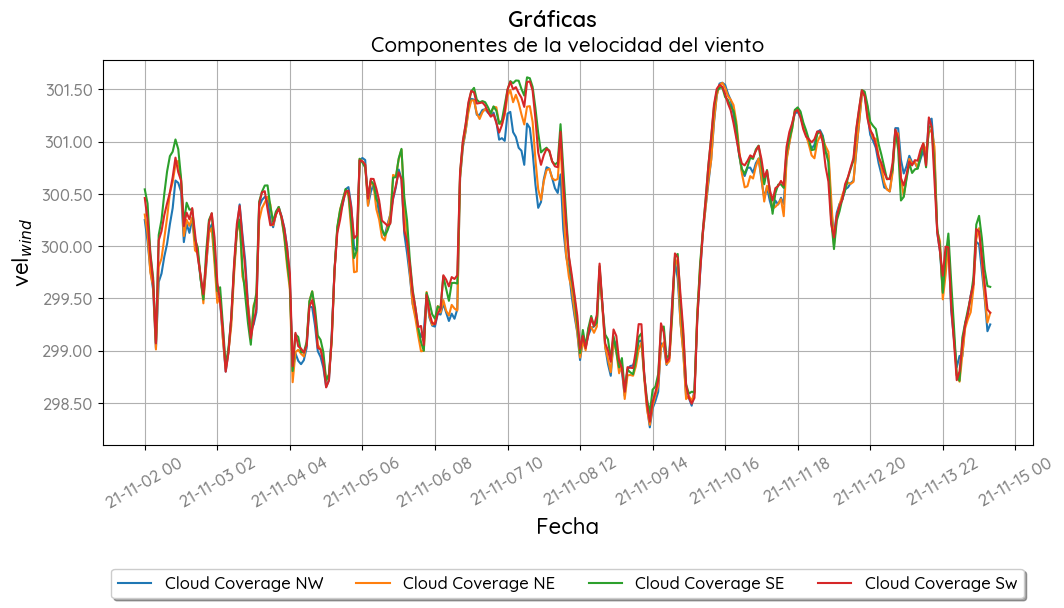

In [16]:
hourticks = ((time_d3d_wind[-1]-time_d3d_wind[0]).days*24 +(time_d3d_wind[-1]-time_d3d_wind[0]).seconds/3600+12) # Mover parámetro 12
xticks_time = np.array([time_d3d_wind[0] + timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12

fig, ax = plt.subplots(figsize=(12,5))

ax.plot(time_d3d_wind, t2m[ind_ini_fin[0]:ind_ini_fin[1],2,2], label = 'Cloud Coverage NW')
ax.plot(time_d3d_wind, t2m[ind_ini_fin[0]:ind_ini_fin[1],3,2], label = 'Cloud Coverage NE')
ax.plot(time_d3d_wind, t2m[ind_ini_fin[0]:ind_ini_fin[1],3,3], label = 'Cloud Coverage SE')
ax.plot(time_d3d_wind, t2m[ind_ini_fin[0]:ind_ini_fin[1],2,3], label = 'Cloud Coverage Sw')



# ax.plot(time_d3d_wind, d2m[ind_ini_fin[0]:ind_ini_fin[1],2,2], label = 'Dewpoint temperature')
# ax.plot(time_d3d_wind, t2m[ind_ini_fin[0]:ind_ini_fin[1],2,2], label = 'Temperature')
# ax.plot(time_d3d_wind, ssr[ind_ini_fin[0]:ind_ini_fin[1],2,2], label = 'Solar radiation')

# ax.plot(time_d3d, ft_west_a, label = 'f$_t$_1', ms=5, color = 'k')
# ax.plot(time_d3d, ft_south_b, label = 'f$_t$_2', ms=5)
# ax.plot(time_d3d, ft_east_b, label = 'f$_t$_3', ms=5, color = 'c')
# ax.plot(time_d3d, ft_north_a, label = 'f$_t$_4', ms=5,color = 'green')
ax.set_xticks(xticks_time)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel ('Fecha',size=16,fontproperties=prop1)
ax.set_ylabel ('vel$_{wind}$',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
for label in ax.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig.suptitle("Gráficas", size = 16,fontproperties=prop2)     # Titulo de la figura
ax.set_title('Componentes de la velocidad del viento',size = 15,fontproperties=prop1)   # Subtítulo de la figura
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation=30)
ax.grid(True)

In [22]:
minutes = np.array([((time_d3d_wind[i] - time_d3d_wind[0]).days*1440)+((time_d3d_wind[i] - time_d3d_wind[0]).seconds/60) for i in range (0,len(time_d3d_wind))])
df_data_heat = pd.DataFrame({'minutes':minutes,'tcc':tcc[ind_ini_fin[0]:ind_ini_fin[1],2,2]*100,'t2m':t2m[ind_ini_fin[0]:ind_ini_fin[1],2,2]-273.15, 
'd2m':d2m[ind_ini_fin[0]:ind_ini_fin[1],2,2]-273.15,'ssr':ssr[ind_ini_fin[0]:ind_ini_fin[1],2,2]})
df_data_heat['hum'] =(4.596*np.exp(17.27*df_data_heat['d2m']/(237.3+df_data_heat['d2m'])))*100/(4.596*np.exp(17.27*df_data_heat['t2m']/(237.3+df_data_heat['t2m'])))
df_heat = df_data_heat[['minutes','hum','t2m','tcc','ssr']]

In [23]:
df_heat

,minutes,hum,t2m,tcc,ssr
0,0.0,85.029092,27.100651,75.174837,5.684342e-14
1,60.0,85.247720,26.896579,70.035408,5.684342e-14
2,120.0,86.381040,26.624898,81.840225,5.684342e-14
3,180.0,86.401453,26.431936,81.649480,5.684342e-14
4,240.0,88.683417,25.873366,89.044277,5.684342e-14
...,...,...,...,...,...
299,17940.0,87.369820,26.868775,76.513103,5.026459e+02
300,18000.0,88.865844,26.615452,78.148931,4.953414e+02
301,18060.0,89.612107,26.358862,79.624533,3.312309e+02
302,18120.0,90.138996,26.037040,92.439535,2.996581e+02


In [24]:
path = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
file_name = 'data_heat_flux.tem'
np.savetxt(path+'/'+file_name, df_heat.values, delimiter='  ', fmt = "%.7f" ) 